In [6]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as dtst
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split, Dataset
from tqdm import tqdm
import numpy as np
import pickle
from model import Generator, Discriminator


device = 'mps' if torch.backends.mps.is_available() else 'cuda:0'
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [7]:
transforms = Compose([ToTensor(), Normalize((0.5,), (0.5, ))])
mnist_full = MNIST(root='train', train=True, download=False, transform=transforms)

In [8]:
def visualize(images, epoch):
    plt.figure(figsize=(16,4))
    for i in range(8):
        plt.subplot(1,8,i+1)
        plt.imshow(images[i], cmap='gray')
        plt.axis('off')
    print(f"Epoch: {epoch+1}")
    plt.show()

Epoch: 0


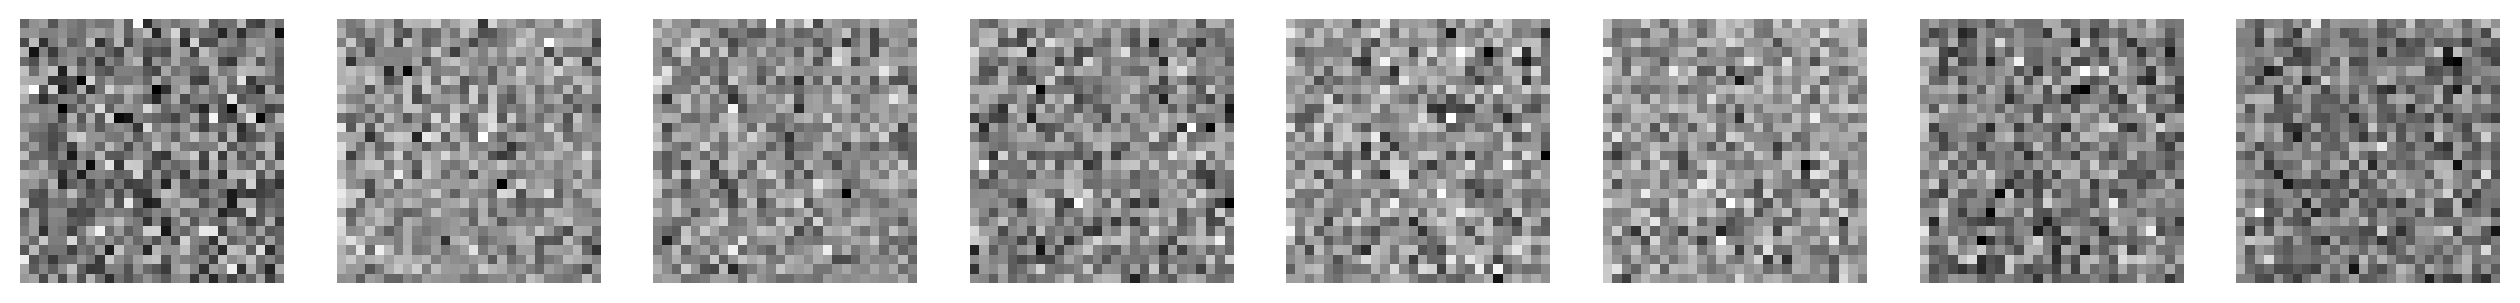

In [9]:
BATCH_SIZE = 256
LATENT_DIM = 128
N_EPOCHS = 30
LR_G = 3e-4
LR_D = 3e-5

train = DataLoader(mnist_full, batch_size=BATCH_SIZE, shuffle=True)
generator = Generator(LATENT_DIM).to(device)
discriminator = Discriminator().to(device)

opt_gen = torch.optim.Adam(generator.parameters(), lr=LR_G)
opt_dis = torch.optim.Adam(discriminator.parameters(), lr=LR_D)
criterion = nn.BCELoss()


VALIDATION  = torch.randn(8, LATENT_DIM).to(device)
with torch.no_grad():
    generator.eval()
    fake_imgs = generator(VALIDATION).detach()
    fake_imgs = fake_imgs.view(-1, 28, 28).cpu().numpy()
    visualize(fake_imgs, -1)

In [10]:
history = {'g_loss':[], 'd_loss':[]}

for epoch in range(N_EPOCHS):
    # Progress bar
    N = len(train)
    pbar = tqdm(enumerate(train), total=N, desc=f"Epoch {epoch+1}/{N_EPOCHS}")
    generator.train()
    discriminator.train()
    run_dloss = 0
    run_gloss = 0
    total = 0
    for k, (real_imgs, _) in pbar:
        real_imgs = real_imgs.to(device)
        # noise
        z = torch.randn(real_imgs.shape[0], LATENT_DIM).type_as(real_imgs)
        ########################################################################
        # generator  training max log (D(G(z)))
        
        fake_imgs = generator(z)
        y_hat = discriminator(fake_imgs)

        y_fake = torch.ones(real_imgs.shape[0], 1)
        y_fake = y_fake.type_as(real_imgs)
        g_loss = criterion(y_hat, y_fake)
        
        opt_gen.zero_grad()
        g_loss.backward()
        opt_gen.step()
        run_gloss += g_loss.item() 
        
        ########################################################################
        # discriminator training max log D(x) + log ( 1- D(G(z)))
        
        y_hat_real = discriminator(real_imgs)
        y_real = torch.ones(real_imgs.shape[0], 1).type_as(real_imgs)
        real_loss = criterion(y_hat_real, y_real)
        
        z = generator(z).detach()
        y_hat_fake = discriminator(z)
        y_fake = torch.zeros(real_imgs.shape[0], 1).type_as(real_imgs)
        fake_loss = criterion(y_hat_fake, y_fake)
        d_loss =  (real_loss + fake_loss)/2
        
        opt_dis.zero_grad()
        d_loss.backward()
        opt_dis.step()
        run_dloss += d_loss.item()
        
        # Update the progress bar
        pbar.set_postfix(g_loss = f"{run_gloss/N:.3f}", d_loss=f"{run_dloss/N:.3f}")
    
    history['g_loss'].append(run_gloss)
    history['d_loss'].append(run_dloss)
        
    # Saving fake images
    with torch.no_grad():
        generator.eval()
        fake_imgs = generator(VALIDATION.type_as(real_imgs)).detach()
        fake_imgs = fake_imgs.view(-1, 28, 28).cpu().numpy()
        visualize(fake_imgs, epoch)

Epoch 1/30:   0%|          | 0/235 [00:00<?, ?it/s]

Epoch 1/30:   0%|          | 0/235 [00:00<?, ?it/s]


RuntimeError: Calculated padded input size per channel: (3 x 3). Kernel size: (4 x 4). Kernel size can't be greater than actual input size

: 